In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from scipy.ndimage.morphology import distance_transform_edt as bwdist

from numpy.linalg import norm
from math import *
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

### Helper functions

In [2]:
def grid_map(obstacles, nrows=500, ncols=500):
    """ Obstacles dicretized map """
    grid = np.zeros((nrows, ncols));
    # rectangular obstacles
    for obstacle in obstacles:
        x1 = meters2grid(obstacle[0][1]); x2 = meters2grid(obstacle[2][1])
        y1 = meters2grid(obstacle[0][0]); y2 = meters2grid(obstacle[2][0])
        grid[x1:x2, y1:y2] = 1

    return grid

In [3]:
def meters2grid(pose_m, nrows=500, ncols=500):
    # [0, 0](m) -> [250, 250]
    # [1, 0](m) -> [250+100, 250]
    # [0,-1](m) -> [250, 250-100]
    if np.isscalar(pose_m):
        pose_on_grid = int( pose_m*100 + ncols/2 )
    else:
        pose_on_grid = np.array( np.array(pose_m)*100 + np.array([ncols/2, nrows/2]), dtype=int )
    return pose_on_grid
def grid2meters(pose_grid, nrows=500, ncols=500):
    # [250, 250] -> [0, 0](m)
    # [250+100, 250] -> [1, 0](m)
    # [250, 250-100] -> [0,-1](m)
    if np.isscalar(pose_grid):
        pose_meters = (pose_grid - ncols/2) / 100.0
    else:
        pose_meters = ( np.array(pose_grid) - np.array([ncols/2, nrows/2]) ) / 100.0
    return pose_meters

In [4]:
def draw_map(obstacles):
    # Obstacles. An obstacle is represented as a convex hull of a number of points. 
    # First row is x, second is y (position of vertices)

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]

    # Draw obstacles
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )

In [5]:
def draw_gradient(f, nrows=500, ncols=500):
    skip = 10
    [x_m, y_m] = np.meshgrid(np.linspace(-2.5, 2.5, ncols), np.linspace(-2.5, 2.5, nrows))
    [gy, gx] = np.gradient(-f);
    Q = plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

#### RRT algorithm

Helper functions

In [6]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            # print 'collision'
            return collFree

    return collFree

In [7]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

RRT algorithm

In [8]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [9]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [10]:
def rrt_path(obstacles, xy_start, xy_goal, params):
    # Initialize RRT. The RRT will be represented as a list of nodes.
    # So each column represents a vertex of the tree.
    rrt = []
    start_node = Node()
    start_node.p = xy_start
    start_node.i = 0
    start_node.iPrev = 0
    rrt.append(start_node)
    nearGoal = False # This will be set to true if goal has been reached
    minDistGoal = params.minDistGoal # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
    d = params.extension # Extension parameter: this controls how far the RRT extends in each step.

    # RRT algorithm
    start_time = time.time()
    iters = 0
    print ('Configuration space sampling started ...')
    while not nearGoal: # and iters < maxiters:
        # Sample point
        rnd = random()
        # With probability goal_prob, sample the goal. This promotes movement to the goal.
        if rnd < params.goal_prob:
            xy = xy_goal
        else:
            # Sample (uniformly) from space (with probability 0.95). The space is defined
            # with the bounds world_bounds_x and world_bounds_y defined above.
            # So, the x coordinate should be sampled in the interval
            # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
            xy = np.array([random()*2*params.world_bounds_x[1]-params.world_bounds_x[1], random()*2*params.world_bounds_x[1]-params.world_bounds_x[1]]) # Should be a 2 x 1 vector
        # Check if sample is collision free
        collFree = isCollisionFreeVertex(obstacles, xy)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

        # If it is collision free, find closest point in existing tree. 
        closest_node = closestNode(rrt, xy)
        
        # Extend tree towards xy from closest_vert. Use the extension parameter
        # d defined above as your step size. In other words, the Euclidean
        # distance between new_vert and closest_vert should be d.
        new_node = Node()
        new_node.p = closest_node.p + d * (xy - closest_node.p)
        new_node.i = len(rrt)
        new_node.iPrev = closest_node.i

        # Check if new vertice is in collision
        collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue
        
        if params.animate:
            # plt.plot(xy[0], xy[1], 'ro', color='k')
            plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES
            plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color='blue') # EDGES
#             plt.draw()
#             plt.pause(0.01)


        # If it is collision free, add it to tree    
        rrt.append(new_node)

        # Check if we have reached the goal
        if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
            # Add last, goal node
            goal_node = Node()
            goal_node.p = xy_goal
            goal_node.i = len(rrt)
            goal_node.iPrev = new_node.i
            if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
                rrt.append(goal_node)
                P = [goal_node.p]
            else: P = []

            end_time = time.time()
            nearGoal = True
            print ('Reached the goal after %.2f seconds:' % (end_time - start_time))

        iters += 1

    print ('Number of iterations passed: %d / %d' %(iters, params.maxiters))
    print ('RRT length: ', len(rrt))

    # Path construction from RRT:
    print ('Constructing the path...')
    i = len(rrt) - 1
    while True:
        i = rrt[i].iPrev
        P.append(rrt[i].p)
        if i == 0:
            print ('Reached RRT start node')
            break
    P = np.array(P)
    # plt.plot( P[:,0], P[:,1], color='green', linewidth=5, label='path from RRT' )

    return P

In [11]:
def ShortenPath(P, obstacles, smoothiters=10):
    # INPUTS
    #   P - path to get smoothed (after RRT algorithm)
    #   obstacles - says where the obstacles are
    #   smoothiters - maximum number of smoothing iterations
    #
    # OUTPUTS
    #   P_smoothed - a path, same format as before:  
    #    P_smoothed = [q1 q2 q3 ... qM]
    #               where q1=qstart and qM=qgoal; in other words, the sequence
    #               of straight-line paths from q1 to q2, q2 to q3, etc., takes
    #               the robot from start to goal without collision
    m = P.shape[0]
    l = np.zeros(m)
    for k in range(1, m):
        l[k] = norm(P[k,:]-P[k-1,:]) + l[k-1] # find all of the straight-line distances
    iters = 0
    while iters < smoothiters:
        s1 = random()*l[m-1] 
        s2 = random()*l[m-1]
        if s2 < s1:
            temps = s1
            s1 = s2
            s2 = temps
        for k in range(1, m):
            if s1 < l[k]:
                i = k - 1
                break
        for k in range(i, m):
            if s2 < l[k]:
                j = k - 1
                break
        if (j <= i):
            iters = iters + 1
            continue
        t1 = (s1 - l[i]) / (l[i+1]-l[i])
        gamma1 = (1 - t1)*P[i,:] + t1*P[i+1,:]
        t2 = (s2 - l[j]) / (l[j+1]-l[j])
        gamma2 = (1 - t2)*P[j,:] + t2*P[j+1,:]
        
        collisionFree = isCollisionFreeEdge(obstacles, gamma1, gamma2)
        if collisionFree == 0:
            iters = iters + 1
            continue
#         print round(l[i],2), round(s1,2), round(l[i+1],2)
#         plt.plot(P[i,0], P[i,1], 'ro', markersize=10, color='red')
#         plt.plot(gamma1[0], gamma1[1], 'ro', markersize=10, color='green')
#         plt.plot(P[i+1,0], P[i+1,1], 'ro', markersize=10, color='blue')
#         plt.plot(P[j,0], P[j,1], 'ro', markersize=10, color='red')
#         plt.plot(gamma2[0], gamma2[1], 'ro', markersize=10, color='green')
#         plt.plot(P[j+1,0], P[j+1,1], 'ro', markersize=10, color='blue')
#         plt.plot([gamma1[0], gamma2[0]], [gamma1[1], gamma2[1]], color='k', linewidth=5)

#         print round(l[j],2), round(s2,2), round(l[j+1],2)
        P = np.vstack([P[:(i+1),:], gamma1, gamma2, P[(j+1):,:]])
        m = P.shape[0]
        l = np.zeros(m)
        for k in range(1, m):
            l[k] = norm( P[k,:] - P[k-1,:] ) + l[k-1]
        iters = iters + 1
#         plt.plot(P[:,0], P[:,1], '--', linewidth=3)
    P_short = P
    
    return P_short

In [12]:
def waypts2setpts(P, params):
	"""
	construct a long array of setpoints, traj_global, with equal inter-distances, dx,
	from a set of via-waypoints, P = [[x0,y0], [x1,y1], ..., [xn,yn]]
	"""
	V = params.drone_vel # [m/s]
	freq = params.ViconRate; dt = 1./freq
	dx = V * dt
	traj_global = np.array(P[-1])
	for i in range(len(P)-1, 0, -1):
		A = P[i]
		B = P[i-1]

		n = (B-A) / norm(B-A)
		delta = n * dx
		N = int( norm(B-A) / norm(delta) )
		sp = A
		traj_global = np.vstack([traj_global, sp])
		for i in range(N):
			sp += delta
			traj_global = np.vstack([traj_global, sp])
		sp = B
		traj_global = np.vstack([traj_global, sp])

	return traj_global

#### Obstacles map construction

In [13]:
class RRT_Params:
    def __init__(self):
        self.animate = 1 # show RRT construction, set 0 to reduce time of the RRT algorithm
        self.visualize = 1 # show constructed paths at the end of the RRT and path smoothing algorithms
        self.maxiters = 5000 # max number of samples to build the RRT
        self.goal_prob = 0.05 # with probability goal_prob, sample the goal
        self.minDistGoal = 0.25 # [m], min distance os samples from goal to add goal node to the RRT
        self.extension = 0.2 # [m], extension parameter: this controls how far the RRT extends in each step.
        self.world_bounds_x = [-2.5, 2.5] # [m], map size in X-direction
        self.world_bounds_y = [-2.5, 2.5] # [m], map size in Y-direction
        self.drone_vel = 0.3 # [m/s]
        self.ViconRate      = 200 # [Hz]

# Initialization
params = RRT_Params()
xy_start = np.array([1.2, 1.0])
xy_goal =  np.array([1.5, -1.4])

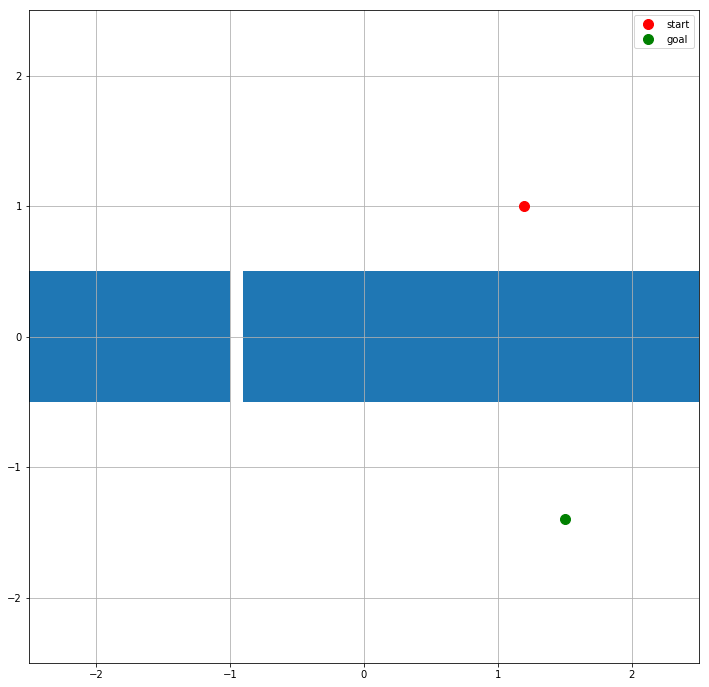

In [14]:
# obstacles = [
#               # bugtrap
#               np.array([[0.5, 0], [2.5, 0.], [2.5, 0.3], [0.5, 0.3]]),
#               np.array([[0.5, 0.3], [0.8, 0.3], [0.8, 1.5], [0.5, 1.5]]),
#               np.array([[0.5, 1.5], [1.5, 1.5], [1.5, 1.8], [0.5, 1.8]]),
#               # angle
#               np.array([[-2, -2], [-0.5, -2], [-0.5, -1.8], [-2, -1.8]]),
#               np.array([[-0.7, -1.8], [-0.5, -1.8], [-0.5, -0.8], [-0.7, -0.8]]),
#               # walls
#               np.array([[-2.5, -2.5], [2.5, -2.5], [2.5, -2.49], [-2.5, -2.49]]),
#               np.array([[-2.5, 2.49], [2.5, 2.49], [2.5, 2.5], [-2.5, 2.5]]),
#               np.array([[-2.5, -2.49], [-2.49, -2.49], [-2.49, 2.49], [-2.5, 2.49]]),
#               np.array([[2.49, -2.49], [2.5, -2.49], [2.5, 2.49], [2.49, 2.49]]),
#             ]

obstacles = [
              np.array([[-2.5, -0.5], [-1.0, -0.5], [-1.0, 0.5], [-2.5, 0.5]]),
              np.array([[-0.9, -0.5], [2.5, -0.5], [2.5, 0.5], [-0.9, 0.5]]),
]
obstacles_grid = grid_map(obstacles)

plt.figure(figsize=(12,12))
plt.grid()
draw_map(obstacles)
plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=10, label='start')
plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=10, label='goal')
plt.legend()

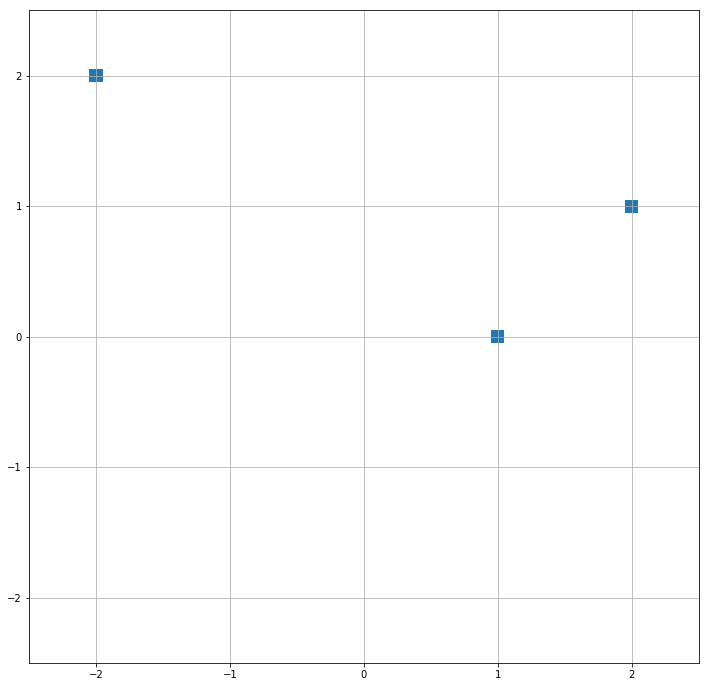

In [27]:
def poses2polygons(poses, l=0.1):
    polygons = []
    for pose in poses:
        pose = np.array(pose)
        polygon = np.array([pose + [-l/2,-l/2], pose + [l/2,-l/2], pose + [l/2,l/2], pose + [-l/2,l/2]])
        polygons.append(polygon)
    return polygons

polygons = poses2polygons([[1,0], [2,1], [-2,2]])

plt.figure(figsize=(12,12))
plt.grid()
draw_map(polygons)

## Global Planner - RRT path

Configuration space sampling started ...
Reached the goal after 343.92 seconds:
Number of iterations passed: 22137 / 5000
RRT length:  8473
Constructing the path...
Reached RRT start node


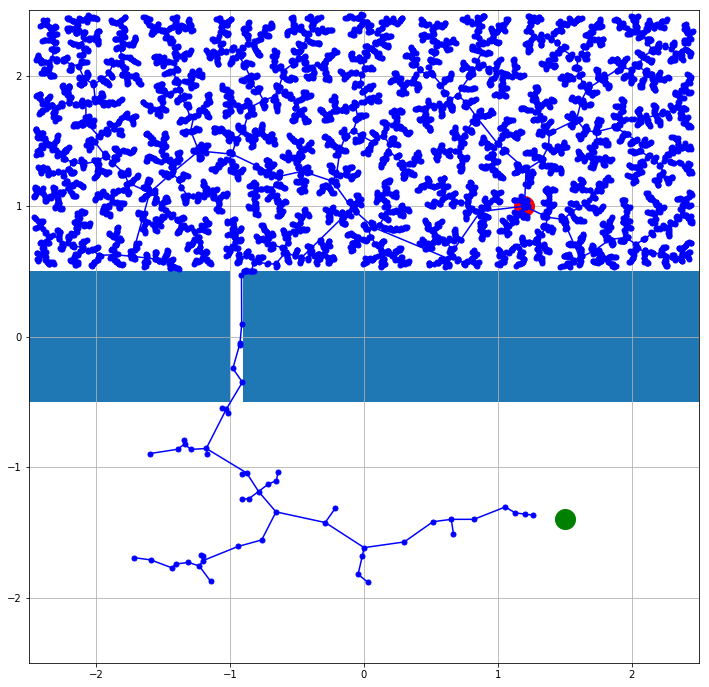

In [30]:
if params.animate:
    plt.figure(figsize=(12,12))
    draw_map(obstacles)
    plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
    plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=20)
    plt.grid()
P = rrt_path(obstacles, xy_start, xy_goal, params)
P_short = ShortenPath(P, obstacles)

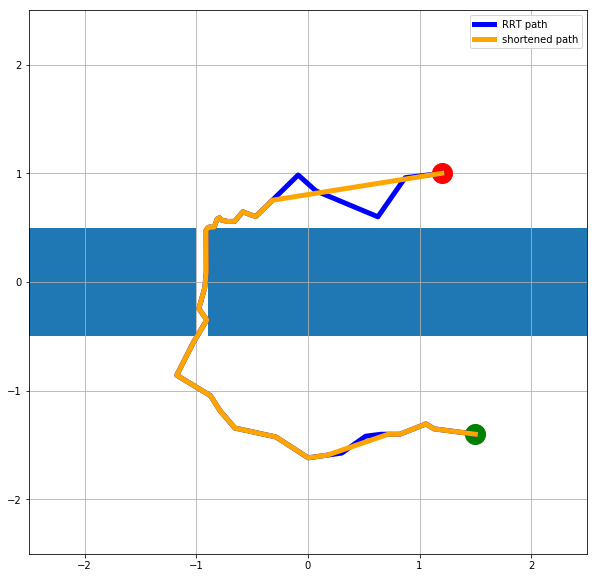

In [31]:
plt.figure(figsize=(10,10))
draw_map(obstacles)

plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=20)

plt.plot( P[:,0], P[:,1], color='blue', linewidth=5, label='RRT path' )
plt.plot(P_short[:,0], P_short[:,1], linewidth=5, color='orange', label='shortened path')
# plt.plot(traj_global[:,0], traj_global[:,1], '.', color='orange', label='smoothed path sps')
plt.legend()
plt.grid()

## Add local planner - Potential Fields

### Potential Fields functions

In [32]:
def combined_potential(obstacles_grid, goal, influence_radius=2, attractive_coef=1./700, repulsive_coef=200, nrows=500, ncols=500):
    """ Repulsive potential """
    goal = meters2grid(goal)
    d = bwdist(obstacles_grid==0)
    d2 = (d/100.) + 1 # Rescale and transform distances
    d0 = influence_radius
    nu = repulsive_coef
    repulsive = nu*((1./d2 - 1./d0)**2)
    repulsive [d2 > d0] = 0
    """ Attractive potential """
    [x, y] = np.meshgrid(np.arange(ncols), np.arange(nrows))
    xi = attractive_coef
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
    """ Combine terms """
    f = attractive + repulsive
    return f

In [33]:
def gradient_planner (f, start, goal, max_its):
    # GradientBasedPlanner : This function plans a path through a 2D
    # environment from a start to a destination based on the gradient of the
    # function f which is passed in as a 2D array. The two arguments
    # start_coords and end_coords denote the coordinates of the start and end
    # positions respectively in the array while max_its indicates an upper
    # bound on the number of iterations that the system can use before giving
    # up.
    # The output, route, is an array with 2 columns and n rows where the rows
    # correspond to the coordinates of the robot as it moves along the route.
    # The first column corresponds to the x coordinate and the second to the y coordinate

    [gy, gx] = np.gradient(-f);
    start_coords = meters2grid(start); end_coords = meters2grid(goal)
    route = np.array( [np.array(start_coords)] )
    for i in range(max_its):
        current_point = route[-1,:];
        # print(sum( abs(current_point-end_coords) ))
        if sum( abs(current_point-end_coords) ) < 5.0:
            # print('Reached the goal !');
            break
        ix = int( current_point[1] )
        iy = int( current_point[0] )
        vx = gx[ix, iy]
        vy = gy[ix, iy]
        dt = 1 / np.linalg.norm([vx, vy]);
        next_point = current_point + dt*np.array( [vx, vy] );
        route = np.vstack( [route, next_point] );
    route = grid2meters(route)
    
    return route

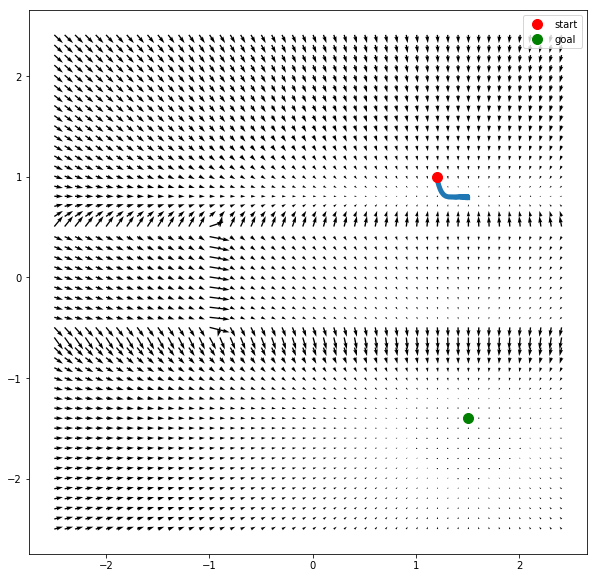

In [34]:
plt.figure(figsize=(10,10))

# Combined potential
f = combined_potential(obstacles_grid, xy_goal)
# Plan route
route = gradient_planner(f, xy_start, xy_goal, 700)

draw_gradient(f)
plt.plot(route[:,0], route[:,1], linewidth=5)
plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=10, label='start')
plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=10, label='goal')
plt.legend()

In [35]:
def layered_planner(P, obstacles_grid):
    """
    Layered Motion Planning:
    inputs: -path from global planner, P
            -obstacles map representation, obstacles_grid
    output: -route, path corrected with potential fields-based
             local planner
    """
    route = np.array([P[-1,:]])

    for i in range(len(P)-1, 0, -1):
        start = route[-1,:]
        goal = P_short[i-1]

        # Combined potential
        f = combined_potential(obstacles_grid, goal)
        
        # Plan route between 2 consequetive waypoints from P
        V = 0.3 # [m/s]
        freq = 100; dt = 1./freq
        dx = V * dt
        route_via = gradient_planner(f, start, goal, 200)
        
        plt.plot(start[0],start[1],'bo',color='red', markersize=10)
        plt.plot(goal[0], goal[1],'bo',color='green', markersize=10)
#         print norm(start-goal) / dx, len(route_via)
        
        route = np.vstack([route, route_via])
        
    return route

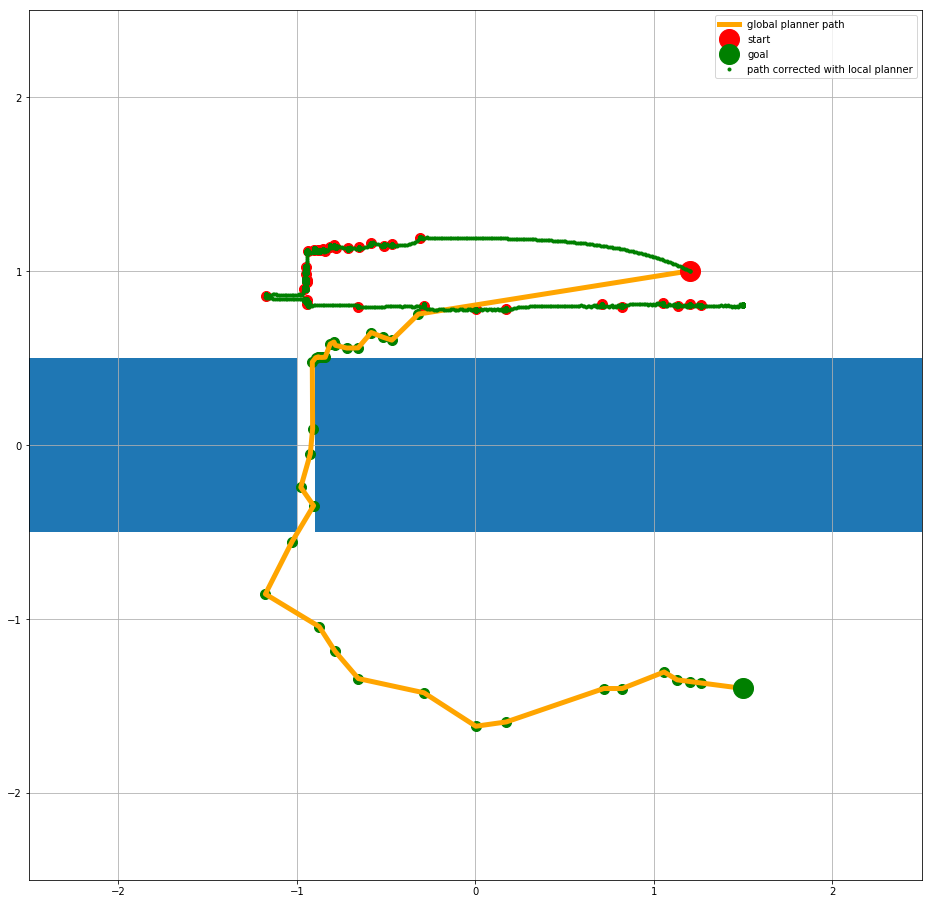

In [36]:
plt.figure(figsize=(16,16))


route = layered_planner(P_short, obstacles_grid)

draw_map(obstacles)
plt.plot(P_short[:,0], P_short[:,1], linewidth=5, color='orange', label='global planner path')
plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20, label='start')
plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=20, label='goal')
plt.grid()    
# draw_gradient(f)
# plt.plot(route[:,0], route[:,1], linewidth=5, color='green', label='path corrected with local planner')
plt.plot(route[:,0], route[:,1], '.', color='green', label='path corrected with local planner')
plt.legend()